In [1]:
import torch
from torch import nn

from torch.utils.data import DataLoader
# DataLoader wraps an iterable around the Dataset

from torchvision import datasets
# torchvision.datasets module contains Dataset objects for many real-world vision data like CIFAR, COCO

from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [3]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",            # root is the path where the train/test data is stored
    train=True,             # train specifies training or test dataset
    download=True,          # download=True downloads the data from the internet if it’s not available at root
    transform=ToTensor(),   # transform and target_transform specify the feature and label transformations
)
# ToTensor() works for the image, whose elements are in range 0 to 255. The entire array is converted to torch tensor 
# and then divided by 255. This is how it is forces the network to be between 0 and 1.

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
training_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

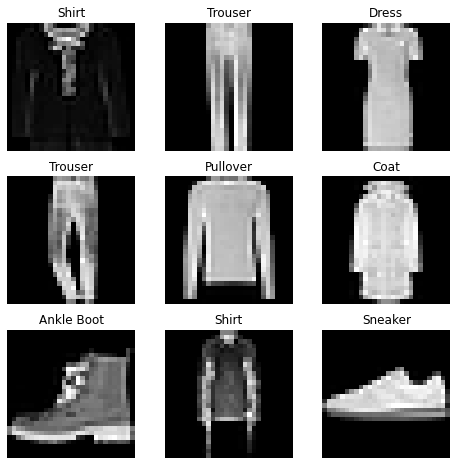

In [5]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [7]:
''' '''  ''' '''# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [8]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [9]:
batch_size  = 64
# define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

#create label loaders
# We pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset, and supports automatic batching, 
# sampling, shuffling and multiprocess data loading.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


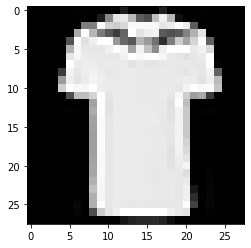

Label: 0


In [12]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [8]:
for X, y in train_dataloader:
  print("Shape of X [N, C, H, W] : ", X.shape)
  print("Shape of y : ", y.shape)
  break

Shape of X [N, C, H, W] :  torch.Size([64, 1, 28, 28])
Shape of y :  torch.Size([64])


In [9]:
for X, y in test_dataloader:
  print("Shape of X [N, C, H, W] : ", X.shape)
  print("Shape of y : ", y.shape)
  break

Shape of X [N, C, H, W] :  torch.Size([64, 1, 28, 28])
Shape of y :  torch.Size([64])


In [10]:
# Define model
# To define a neural network in PyTorch, we create a class that inherits from nn.Module.
class NeuralNetwork(nn.Module):
    # We define the layers of the network in the __init__ function.
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    # specify how data will pass through the network in the forward function.
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
# To accelerate operations in the neural network, we move it to the GPU if available.
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [11]:
# To train a model, we need a loss function and an optimizer.
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [12]:
# In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and 
# backpropagates the prediction error to adjust the model’s parameters.
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [13]:
# We also check the model’s performance against the test dataset to ensure it is learning
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [14]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.303516  [    0/60000]
loss: 2.295898  [ 6400/60000]
loss: 2.275151  [12800/60000]
loss: 2.267922  [19200/60000]
loss: 2.243788  [25600/60000]
loss: 2.217934  [32000/60000]
loss: 2.231213  [38400/60000]
loss: 2.192287  [44800/60000]
loss: 2.194137  [51200/60000]
loss: 2.159522  [57600/60000]
Test Error: 
 Accuracy: 42.3%, Avg loss: 2.152790 

Epoch 2
-------------------------------
loss: 2.164046  [    0/60000]
loss: 2.156286  [ 6400/60000]
loss: 2.100558  [12800/60000]
loss: 2.108981  [19200/60000]
loss: 2.053401  [25600/60000]
loss: 2.003397  [32000/60000]
loss: 2.026877  [38400/60000]
loss: 1.947810  [44800/60000]
loss: 1.957150  [51200/60000]
loss: 1.883614  [57600/60000]
Test Error: 
 Accuracy: 51.6%, Avg loss: 1.875428 

Epoch 3
-------------------------------
loss: 1.912620  [    0/60000]
loss: 1.883439  [ 6400/60000]
loss: 1.766359  [12800/60000]
loss: 1.796175  [19200/60000]
loss: 1.690723  [25600/60000]
loss: 1.652179  [32000/600

In [15]:
# save a model is to serialize the internal state dictionary (containing the model parameters).
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [16]:
# loading a model includes re-creating the model structure and loading the state dictionary into it.
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [18]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[100][0], test_data[100][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Dress", Actual: "Dress"
